In [15]:
import time

from rl4co.envs.scheduling.djssp.env import DJSSPEnv
from rl4co.models import L2DPolicy, L2DModel
from rl4co.utils import RL4COTrainer
import gc
from rl4co.envs import JSSPEnv
from rl4co.models.zoo.l2d.model import L2DPPOModel
from rl4co.models.zoo.l2d.policy import L2DPolicy4PPO
from torch.utils.data import DataLoader
import json
import os
%load_ext autoreload
%autoreload 2
generator_params = {
"num_jobs" : 5 ,
"num_machines": 5 ,
"min_processing_time": 1 ,
"max_processing_time": 99 ,
"mtbf" : 17 ,
"mttr" : 4
}
env = DJSSPEnv(generator_params=generator_params,
_torchrl_mode=True,
stepwise_reward=True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import torch
if torch.cuda.is_available():
    accelerator = "gpu"
    batch_size = 4
    train_data_size = 2_000
    embed_dim = 128
    num_encoder_layers = 4
else:
    accelerator = "cpu"
    batch_size = 2
    train_data_size = 1_000
    embed_dim = 64
    num_encoder_layers = 2

In [17]:
# Policy: neural network, in this case with encoder-decoder architecture
policy = L2DPolicy4PPO(
    embed_dim=embed_dim,
    num_encoder_layers=num_encoder_layers,
    env_name="jssp",
    het_emb=False
)

C:\Program Files\JetBrains\PyCharm 2024.2\plugins\python-ce\helpers\pydev\pydevd_plugins\__init__.py:2: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydevd_plugins')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__('pkg_resources').declare_namespace(__name__)
C:\Program Files\JetBrains\PyCharm 2024.2\plugins\python-ce\helpers\pydev\pydevd_plugins\extensions\__init__.py:2: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pydevd_plugins.extensions')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__('pkg_resources').declare_namespace(__name__)
C:\Program Files\JetBrains\PyCharm 2024.2\plugin

In [18]:
# default decoder
policy.decoder

L2DDecoder(
  (feature_extractor): GCN4JSSP(
    (init_embedding): JSSPInitEmbedding(
      (init_ops_embed): Linear(in_features=5, out_features=64, bias=True)
      (pos_encoder): PositionalEncoding(
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (gcn_layers): ModuleList(
      (0-1): 2 x GCNConv(64, 64)
    )
  )
  (actor): JSSPActor(
    (mlp): MLP(
      (hidden_act): ReLU()
      (out_act): Identity()
      (lins): ModuleList(
        (0-1): 2 x Linear(in_features=64, out_features=64, bias=True)
        (2): Linear(in_features=64, out_features=1, bias=True)
      )
      (input_norm): Identity()
      (output_norm): Identity()
    )
  )
)

In [19]:
# default encoder
policy.encoder

NoEncoder()

In [20]:
def make_step(td, decoder):
    """
    Equivalent to FJSP make_step(), adapted for JSSP where no encoder is used.
    td: TensorDict representing the current state of the environment.
    decoder: The L2DDecoder or policy that generates action logits.
    env: The JSSP environment instance.
    """
    # Directly decode logits and mask from the raw input state `td`
    hidden, _ = decoder.feature_extractor(td)

    logits, mask = decoder(td, num_starts=0 , hidden = hidden)

    # Mask invalid actions by setting their logits to -inf
    action = logits.masked_fill(~mask, -torch.inf).argmax(1)

    # Update the state with the selected action
    td["action"] = action

    # Step the environment with the selected action
    td = env.step(td)["next"]

    return td

In [21]:
td = env.reset(batch_size = [1])

In [22]:
td["proc_times"][0]

tensor([[ 17.9812,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,  89.4566,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          82.2788,   0.0000,   0.0000,   0.0000,   9.4663,   0.0000,   5.4745,
           0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,  74.4607,   0.0000,   0.0000,
          20.5570,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  24.7182,
           0.0000,   0.0000,   0.0000,  25.2249,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,  33.7829],
        [  0.0000,   0.0000,   0.0000,  68.9108,   0.0000,  18.2110,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  43.6149,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,  94.6562,   0.0000,
           0.0000,   0.0000,  31.3497,   0.0000],
        [  0.0000,  19.5372,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,  48.1835,   5.0748,   0.0000,  

<Figure size 640x480 with 0 Axes>

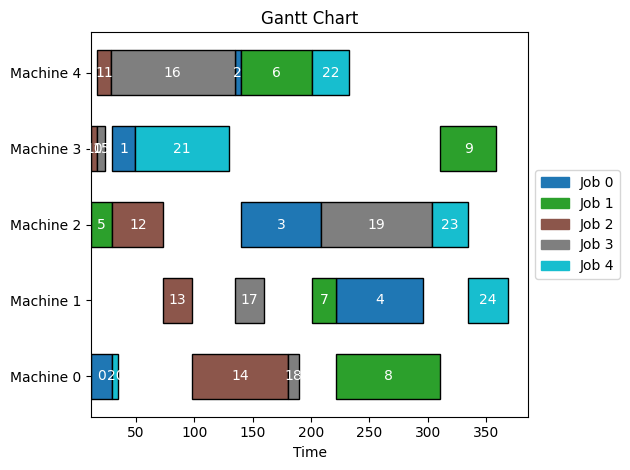

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [23]:
from matplotlib import pyplot as plt
from IPython.core.display_functions import clear_output

env.render(td, 0)
# Update plot within a for loop
while not td["done"].all():
    # Clear the previous output for the next iteration
    clear_output(wait=True)

    td = make_step(td=td ,decoder = policy.decoder)
    env.render(td, 0)
    # Display updated plot
    display(plt.gcf())

    # Pause for a moment to see the changes
    time.sleep(.4)

In [24]:
td["machine_breakdowns"][0]

{0: [{'TIME': 3.000108480453491, 'DURATION': 10.950005531311035},
  {'TIME': 35.32599139213562, 'DURATION': 1.3882921934127808}],
 1: [{'TIME': 21.723852157592773, 'DURATION': 1.9373793601989746},
  {'TIME': 53.32680654525757, 'DURATION': 1.5291308164596558}],
 2: [{'TIME': 7.263213157653809, 'DURATION': 2.711613416671753},
  {'TIME': 52.46433997154236, 'DURATION': 3.8198349475860596}],
 3: [{'TIME': 40.77605056762695, 'DURATION': 1.205381989479065},
  {'TIME': 45.75132215023041, 'DURATION': 0.6587216854095459}],
 4: [{'TIME': 6.723081111907959, 'DURATION': 2.6919376850128174},
  {'TIME': 38.85593867301941, 'DURATION': 0.6645970344543457}]}

In [25]:
td["finish_times"]

tensor([[ 29.5050,  49.0422, 139.8444, 208.7552, 295.8059,  29.7348, 200.7882,
         221.3452, 310.8018, 358.9853,  16.5986,  28.3313,  73.3497,  98.0679,
         180.3467,  23.2319, 134.6127, 159.8376, 189.8130, 303.4113,  34.9795,
         129.9793, 232.3621, 334.7610, 368.5439]])

In [26]:
td["start_times"][0]

tensor([ 11.5238,  29.5050, 134.6127, 139.8444, 221.3452,  11.5238, 139.8444,
        200.7882, 221.3452, 310.8018,  11.5238,  16.5986,  29.7348,  73.3497,
         98.0679,  16.5986,  28.3313, 134.6127, 180.3467, 208.7552,  29.5050,
         49.0422, 200.7882, 303.4113, 334.7610])

In [27]:
td["job_arrival_times"]

tensor([[11.5238, 14.0567, 20.9220, 37.6722, 41.4592]])

In [28]:
job_arr_time = torch.tensor([[11.5238, 14.0567, 20.9220, 37.6722, 41.4592] , [0, 14.0567, 20.9220, 37.6722, 41.4592]])
a = torch.tensor([[0] , [9]])
a = torch.min(job_arr_time , dim = 1)
a

torch.return_types.min(
values=tensor([11.5238,  0.0000]),
indices=tensor([0, 0]))